In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
#import plotly.plotly as py
from plotly.subplots import make_subplots
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
import pywt
from sklearn.metrics import mean_squared_error

In [2]:
dataset=pd.read_csv('sales_train_validation.csv')
date=pd.read_csv('calendar.csv')
sell_price=pd.read_csv('sell_prices.csv')


In [3]:
dataset.head()



,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [4]:
len(dataset['item_id'].unique())

3049

In [5]:
date.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [6]:
sell_price.head()
#sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
d_dates=date['date']
d_dates=d_dates[0: 1913]
d_dates
date.head()


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
#creating sample sales
d_columns = dataset.columns[6:]

sample_1 = dataset.iloc[5][d_columns]
sample_2 = dataset.iloc[11][d_columns]

In [9]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                        y=sample_1,showlegend=True, mode='lines',
                        name='Sample_sales-1',marker_color='RED'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                        y=sample_2,showlegend=True, mode='lines',
                        name='Sample_sales-2',marker_color='BLUE'), 
              row=2, col=1)

fig.update_layout(height=800, width=950, title_text="Sample sales", template='plotly_white')
fig.show()

In [10]:
# maximizing the graph to see the trend and pattern in sales
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_1[600:800])),
                        y=sample_1[600:800],showlegend=True, mode='lines',
                        name='Sample_sales-1',marker_color='RED'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2[200:300])),
                        y=sample_2[200:300],showlegend=True, mode='lines',
                        name='Sample_sales-2',marker_color='BLUE'), 
              row=2, col=1)

fig.update_layout(height=800, width=950, title_text="Sample sales", template='plotly_white')
fig.show()

<h1>Observations</h1>
<p>The above is maximized to see the pattern in the sales for different time frames although we have not included the time frame in the data yet.</p>
<p>As we can clearly see that the graph of the sales is very dynamic and volatile.Sometimes the sales are 0 for few days and then again after some days the sales goes up.Therefore, we need some sort of "denoising" techniques to find the underlying trends in the sales data and make forecasts</p>
<h3 style='color:SlateBlue'>Wavelet denoising</h3>
<p>Wavelet denoising (usually used with electric signals) is a way to remove the unnecessary noise from a time series. This method calculates coefficients called the "wavelet coefficients". These coefficients decide which pieces of information to keep (signal) and which ones to discard (noise).
We make use of the MAD (mean absolute deviation) value to understand the randomness in the sales and accordingly decide the minimum threshold for the wavelet coefficients in the time series. We filter out the low coefficients from the wavelets and reconstruct the sales data from the remaining coefficients and that's it; we have successfully removed noise from the sales data.</p>

In [11]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

In [12]:
denoised_sample_1=denoise_signal(sample_1[600:800])
denoised_sample_2=denoise_signal(sample_2[200:300])
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_1[600:800])),
                        y=sample_1[600:800],showlegend=True, mode='lines',
                        name='Original_1',marker_color='#64B8F3'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(denoised_sample_1)),
                        y=denoised_sample_1,showlegend=True, mode='lines',
                        name='Denoised_1',marker_color='blue'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2[200:300])),
                        y=sample_2[200:300],showlegend=True, mode='lines',
                        name='Original_2',marker_color='#F2B963'), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(denoised_sample_2)),
                        y=denoised_sample_2,showlegend=True, mode='lines',
                        name='Denoised_2',marker_color='RED'), 
              row=2, col=1)

fig.update_layout(height=800, width=950, title_text="Original v/s Denoised", template='plotly_white')
fig.show()

<h3 style='color:SlateBlue'>Average Smoothing</h3>
<p> Average smoothing is one of the simple methods used to average out the details of the data. Here method used is moving average method where a fixed window let's say 4 is fixed so whole dataset is shifted by 4 units and then the mean of first 4 time series is calculated and then thereafter the graph is plotted for the average of previous 4 graphs.Here we can also use 12 units moving avg for much smoothness of the plot.</p>

In [13]:
moving_avg_1=sample_1[600:700].rolling(window=4).mean()
moving_avg_2=sample_2[200:300].rolling(window=4).mean()


In [14]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_1[600:700])),
                        y=sample_1[600:700],showlegend=True, mode='lines',
                        name='Original_1',marker_color='#64B8F3'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(moving_avg_1)),
                        y=moving_avg_1,showlegend=True, mode='lines',
                        name='Denoised_1',marker_color='blue'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2[200:300])),
                        y=sample_2[200:300],showlegend=True, mode='lines',
                        name='Original_2',marker_color='#F2B963'), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(moving_avg_2)),
                        y=moving_avg_2,showlegend=True, mode='lines',
                        name='Denoised_2',marker_color='RED'), 
              row=2, col=1)

fig.update_layout(height=800, width=950, title_text="Original v/s Denoised", template='plotly_white')
fig.show()

<h1>Observations</h1>
<p>Here by comparing both <strong>wavelet denoising</strong>  and <strong>average smoothing</strong> method we can clearly see that wavelet denoising is much more suitable graph for determining the trend of the series rather than average smoothing method. Average smoothing has it's own advantage but here there are unnecessary noises which cannot be used to find any type of trend and hence here we will go with wavelet denoising to remove the noise in our series and hence is more suitable method.
</p>

<h1 align='center',style='color: blue'>Building our time series data frame</h1>


In [15]:
store_id = set(dataset['store_id'])
sales_df = dataset.set_index('id')[d_columns].T.merge(date.set_index('d')['date'],left_index=True,right_index=True,validate='1:1').set_index('date')
sales_df.index = pd.to_datetime(sales_df.index)
sales_df


,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,1,1,1,0,1,0,1,4,0,0,...,4,1,1,0,0,0,0,1,1,0
2016-04-21,3,0,0,1,2,0,0,6,0,0,...,2,3,3,0,2,1,0,0,0,0
2016-04-22,0,0,1,3,2,2,0,3,0,2,...,0,1,6,0,3,0,0,0,3,0


In [16]:
fig = go.Figure()
for store in store_id:
    store_columns = [c for c in sales_df.columns if store in c]
    df = sales_df[store_columns].sum(axis=1)
    df.columns = ['date','sum']
    df = df.groupby(pd.Grouper(freq="M")).mean()

In [17]:
fig = go.Figure()
for store in store_id:
    store_columns = [c for c in sales_df.columns if store in c]
    df = sales_df[store_columns].sum(axis=1)
    df.columns = ['date','sum']
    df = df.groupby(pd.Grouper(freq="M")).mean()
    fig.add_trace(go.Scatter(x=df.index, y=df, name=store))

fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Monthy Average Sales (per store)", template='plotly_white',
                     xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='12m', step='month', stepmode='backward'),
                dict(count=18, label='18m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    ))

<h1 style='color:blue'>Observations</h1>
<p>The above plot is the monthly sales of stores located in various cities. Here on the right of the plot the index shows the store ids of different stores.From the graph the following observations can be made:</p> 
<ol>  
    <li>From the above plot we can clearly see that sales drastically decreases during the months of november and december.</li>
    <li>Sales increases during the months of July and August and Mid-Semtember</li>
</ol>
<p>Now let's see and observe the sales state wise.</p>

In [18]:
state_id=set(dataset['state_id'])
fig = go.Figure()
for state in state_id:
    state_columns = [c for c in sales_df.columns if state in c]
    df = sales_df[state_columns].sum(axis=1)
    df.columns = ['date','sum']
    df = df.groupby(pd.Grouper(freq="M")).mean()
    fig.add_trace(go.Scatter(x=df.index, y=df, name=state))

fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Monthy Average Sales (per state)", template='plotly_white',
                     xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='12m', step='month', stepmode='backward'),
                dict(count=18, label='18m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    ))


<h1 style='color:blue'>Observations</h1>
<p>The above plot is the monthly average sales of stores state wise. Here on the right of the plot the index shows the state ids of 3 different states of USA.</p>
<p>Here are the states id's corresponding to different states.</p>
<li> CA - California</li>
<li> TX - Texas</li>
<li> WX - Winston</li>
<p> The following observations can be made from the plots:</p>
<ol>  
    <li>By region wise California has maximum number of sales per month as compared to other states.</li>
    <li>Sales are highest during the months of July and August and Mid-Semtember</li>
    <li>Sales are lowest during the months of november and December</li>
</ol>

In [19]:
# creating training and test sets
train_df = sales_df[-100:-30]
test_df = sales_df[-30:]
train_df

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2016-01-16,0,0,0,3,0,4,1,47,0,0,...,3,4,2,3,2,0,0,3,0,2
2016-01-17,0,0,0,2,1,0,0,5,0,0,...,1,5,2,2,2,0,0,1,4,2
2016-01-18,0,1,0,4,0,0,0,48,0,0,...,0,4,0,1,1,0,0,0,4,0
2016-01-19,2,0,0,3,0,0,0,4,0,0,...,3,1,1,0,2,0,0,2,2,1
2016-01-20,1,0,0,1,0,8,0,16,0,1,...,0,0,3,1,0,1,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-21,1,0,0,4,2,0,1,2,0,0,...,2,3,1,0,4,0,0,2,1,2
2016-03-22,2,0,0,1,3,2,0,13,0,0,...,1,1,1,0,2,0,0,0,0,0
2016-03-23,2,0,0,3,1,0,0,10,0,0,...,2,4,1,0,2,0,0,0,2,5


In [20]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_df.index, y=train_df[train_df.columns[0]]))
fig.add_trace(go.Scatter(x=test_df.index, y=test_df[train_df.columns[0]]))
fig.update_layout(height=500, width=900, title_text="Train & Validation", template='plotly_white')

In [21]:
# Augmented dicky fuller test for measuring non stationarity and stationarity for small training dataset
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_df[train_df.columns[2]])
print('Test Statistic : ',result[0])
print('P-value : ',np.round(result[1],decimals=15))


Test Statistic :  -7.1813602314140175
P-value :  2.64468e-10


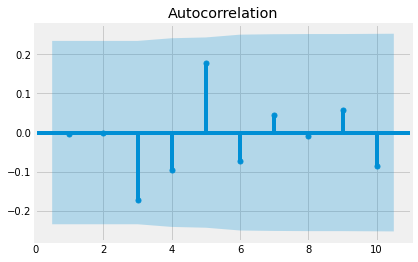

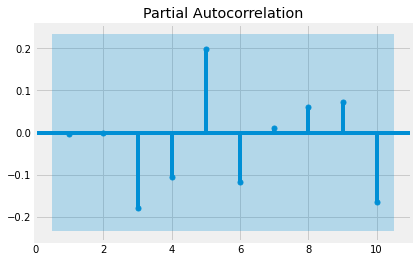

In [22]:
#plotting acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot = plot_acf(train_df[train_df.columns[0]], lags=10, zero=False, alpha=0.05)
plot = plot_pacf(train_df[train_df.columns[0]], lags=10, zero=False, alpha=0.05)

<h2>Observations</h2>
<p>From the above autocorrelations and partial autocorrelations we can see that the daywise sales are quite stationary since p value is very small.</p>

<h1>Modelling on entire 1 year</h1>

In [68]:
# augmented dicky fuller test used for measuring stationarity in average monthly sales per state
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig=go.Figure()

for state in state_id:
    state_columns = [c for c in sales_df.columns if state in c]
    df = sales_df[state_columns].sum(axis=1)
    df.columns = ['date','sum']
    df = df.groupby(pd.Grouper(freq="M")).mean()
    fig.add_trace(go.Scatter(x=df.index, y=df, name=state))
    result= adfuller(df)
    print('Test Statistic : ',result[0])
    print('P-value of: '+state,np.round(result[1],decimals=15))



Test Statistic :  -0.13868222617780385
P-value of: WI 0.945446717834636
Test Statistic :  -3.2492676383304917
P-value of: TX 0.017304220438264
Test Statistic :  -1.704069905201306
P-value of: CA 0.429016768674967


<h2 style='color: blue'>Modelling on avg monthly sales of stores in California</h2>

In [69]:
# Creating monthly average for CA
store_columns = [c for c in sales_df.columns if 'CA' in c]
df = sales_df[store_columns].sum(axis=1)
df.columns = ['date','sum']
df = df.groupby(pd.Grouper(freq="M")).mean()

df_train=df.loc['2011-01-31':'2015-12-31']
df_test=df.loc['2015-12-31':]
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train, name='training_set'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test, name='testing_set'))
fig.update_layout(height=500, width=900, title_text="Train & Validation for California", template='plotly_white')

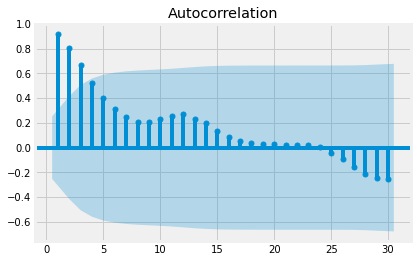

In [70]:
#plotting acf plot
plot= plot_acf(df_train, lags=30, zero=False)

<h2>Observations</h2>
<p> As we can see by autocorrelation curve the plot is non stationary and hence we need to make it stationary.Hence we will go by method of differencing</p>

Test Statistic :  -1.625529026329556
P-value of: CA 0.469831852944227


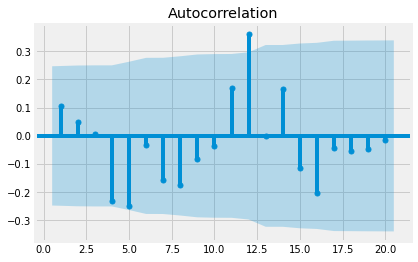

In [71]:
# shifting the column and differencing  'dft' is difference dataframe 1
dft=df-df.shift(1)
dft=dft.dropna()
dft.head()
plot= plot_acf(dft, lags=20, zero=False)
dft_train=dft['2011-02-28':'2015-12-31']
dft_test=dft['2015-12-31': '2016-04-30']
result= adfuller(dft)
print('Test Statistic : ',result[0])
print('P-value of: '+state,np.round(result[1],decimals=15))




<p>By 1st order differencing we can clearly see the p value has drastically reduced and by seeing our autocorrelation plot we can see that our plot has now become stationary</p>

In [72]:
#building Seasonal arima function
import pmdarima as pm
results = pm.auto_arima(dft_train,d=0, # Non-Seasonal difference order 
                           start_p=1, #Initial guess for p
                           start_q=1, #Intial guess for q
                           max_d=3,
                           max_p=3, 
                           max_q=3,
                           seasonal=True , #Times series is seasonal
                           m=12, #Seasonal Period
                           D=2, #Seasonal Difference order
                           start_P=1, #Initial guess for P
                           start_Q=1, #Intial guess for Q
                           max_P=2, 
                           max_Q=2,
                           information_criterion='aic', #To select Best model
                           trace = True, #print results while training
                           error_action = 'ignore', #ignore orders that don't work
                           stepwise=True #Apply intelligent order search
                           )


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,2,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=587.398, Time=0.02 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=582.270, Time=0.09 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,2,0)[12]             : AIC=589.191, Time=0.09 sec
 ARIMA(1,0,0)(2,2,0)[12]             : AIC=578.251, Time=0.54 sec
 ARIMA(1,0,0)(2,2,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(1,0,0)(1,2,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(2,2,0)[12]             : AIC=576.363, Time=0.40 sec
 ARIMA(0,0,0)(1,2,0)[12]             : AIC=580.155, Time=0.24 sec
 ARIMA(0,0,0)(2,2,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,0,0)(1,2,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,1)(2,2,0)[12]             : AIC=578.263, Time=0.41 sec
 ARIMA(1,0,1)(2,2,0)[12]             : AIC=580.357, Time=0.72 sec
 ARIMA(0,0,0)(2,2,0)[12] intercept   : AIC=578.333, Time=

In [73]:
#building our SARIMAX Model using above parameters
from statsmodels.tsa.statespace.sarimax import SARIMAX
predictions = []
model = SARIMAX(dft_train,order=(0,0,0), seasonal_order=(2,2,0,12), trend='c')
results = model.fit()
predictions = results.forecast(12)

# converting differenced value into standard value
dftt_train=dft_train+df_train.shift(1)
dftt_train=dftt_train.dropna()
dftt_test=dft_test+df_test.shift(1)
dftt_test=dftt_test.dropna()
dftt_train[58]
dftt_train.tail()

for i in range(len(predictions)):
    if i==0:
        predictions[i]=predictions[i]+dftt_train[58]
    else:
        predictions[i]=predictions[i]+predictions[i-1]
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train, name='training_set'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test, name='testing_set'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, name='predictions'))
fig.update_layout(height=500, width=900, title_text="Forecasting California Sales for next 12 months using seasonal ARIMA model", template='plotly_white')

In [74]:
# Calculating root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
expected = dftt_test.iloc[1:]
prediction = predictions[:3]
mse = mean_squared_error(expected, prediction)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 1091.776559


<h2 style='color: blue'>Modelling on avg monthly sales of stores in Texas</h2>

In [97]:
# Creating monthly average for CA
store_columns = [c for c in sales_df.columns if 'TX' in c]
df = sales_df[store_columns].sum(axis=1)
df.columns = ['date','sum']
df = df.groupby(pd.Grouper(freq="M")).mean()

#splitting the data into training and test set
df_train=df['2011-01-31':'2015-12-31']
df_test=df['2015-12-31': '2016-04-30']
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train, name='training_set'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test, name='testing_set'))
fig.update_layout(height=500, width=900, title_text="Train & Validation of TEXAS sales", template='plotly_white')

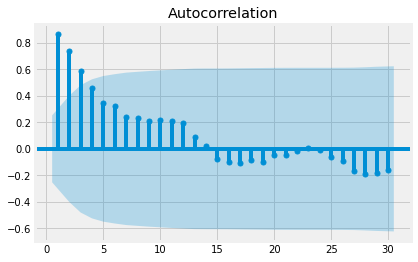

In [98]:
plot= plot_acf(df_train, lags=30, zero=False)

<h2>Observations</h2>
<p> As we can see by autocorrelation curve the plot is non stationary and hence we need to make it stationary.Hence we will go by method of differencing</p>

Test Statistic :  -1.855334076409642
P-value of: CA 0.353356064493935


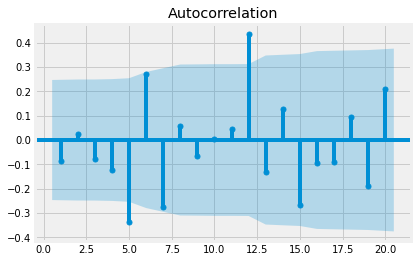

In [99]:
# shifting the column and differencing  'dft' is difference dataframe 1
dft=df-df.shift(1)
dft=dft.dropna()
dft.head()
plot= plot_acf(dft, lags=20, zero=False)
dft_train=dft['2011-02-28':'2015-12-31']
dft_test=dft['2015-12-31': '2016-04-30']
result= adfuller(dft)
print('Test Statistic : ',result[0])
print('P-value of: '+state,np.round(result[1],decimals=15))



In [79]:
#building Seasonal arima function
results = pm.auto_arima(dft_train,d=1, # Non-Seasonal difference order 
                           start_p=1, #Initial guess for p
                           start_q=1, #Intial guess for q
                           max_d=3,
                           max_p=3, 
                           max_q=3,
                           seasonal=True , #Times series is seasonal
                           m=12, #Seasonal Period
                           D=2, #Seasonal Difference order
                           start_P=1, #Initial guess for P
                           start_Q=1, #Intial guess for Q
                           max_P=2, 
                           max_Q=2,
                           information_criterion='aic', #To select Best model
                           trace = True, #print results while training
                           error_action = 'ignore', #ignore orders that don't work
                           stepwise=True #Apply intelligent order search
                           )


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=580.428, Time=0.02 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=568.566, Time=0.22 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=573.644, Time=0.06 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=560.166, Time=0.50 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=569.394, Time=0.40 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=551.955, Time=0.60 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=554.942, Time=0.34 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=553.792, Time=0.80 sec
 ARIMA(2,1,1)(2,2,0)[12]             : AIC=553.792, Time=

In [116]:
#building our SARIMAX model using above parameters
from statsmodels.tsa.statespace.sarimax import SARIMAX
predictions = []
model = SARIMAX(dft_train,order=(3,0,0), seasonal_order=(2,2,0,12), trend='c')
results = model.fit()
predictions = results.forecast(12)

fig=go.Figure()
fig.add_trace(go.Scatter(x=dft_train.index, y=dft_train, name='training_set'))
fig.add_trace(go.Scatter(x=dft_test.index, y=dft_test, name='testing_set'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, name='predictions'))
fig.update_layout(height=500, width=900, title_text="Forecasting  Sales of TEXAS for next 12 months using seasonal ARIMA model", template='plotly_white')

/home/vinod/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [117]:
# converting differenced value into standard value
predictions = results.forecast(12)
dftt_train=dft_train+df_train.shift(1)
dftt_train=dftt_train.dropna()
dftt_test=dft_test+df_test.shift(1)
dftt_test=dftt_test.dropna()
for i in range(len(predictions)):
    if i==0:
        predictions[i]=predictions[i]+dftt_train[58]
    else:
        predictions[i]=predictions[i]+predictions[i-1]

In [118]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train, name='training_set'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test, name='testing_set'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, name='predictions'))
fig.update_layout(height=500, width=900, title_text="Forecasting TEXAS Sales for next 12 months using seasonal ARIMA model", template='plotly_white')

In [119]:
# Calculating root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
expected = dftt_test.iloc[1:]
prediction = predictions[:3]
mse = mean_squared_error(expected, prediction)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 516.267933


<h2 style='color: blue'>Modelling on avg monthly sales of stores in Winston</h2>

In [120]:
# Creating monthly average for WINSTON
store_columns = [c for c in sales_df.columns if 'WI' in c]
df = sales_df[store_columns].sum(axis=1)
df.columns = ['date','sum']
df = df.groupby(pd.Grouper(freq="M")).mean()
df_train=df['2011-01-31':'2015-12-31']
df_test=df['2015-12-31': '2016-04-30']
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train, name='training_set'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test, name='testing_set'))
fig.update_layout(height=500, width=900, title_text="Train & Validation for Winston", template='plotly_white')

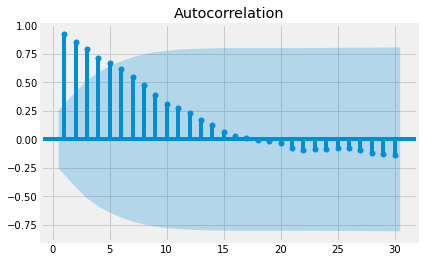

In [121]:
plot= plot_acf(df_train, lags=30, zero=False)

Test Statistic :  -1.3032170609041738
P-value of: CA 0.627699222147686


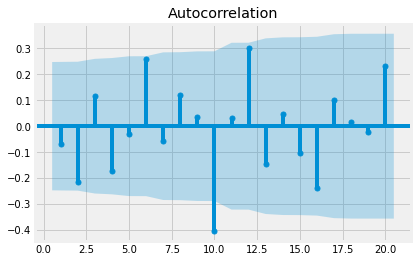

In [122]:
# shifting the column and differencing  'dft' is difference dataframe 1
dft=df-df.shift(1)
dft=dft.dropna()
dft.head()
plot= plot_acf(dft, lags=20, zero=False)
dft_train=dft['2011-02-28':'2015-12-31']
dft_test=dft['2015-12-31': '2016-04-30']
result= adfuller(dft)
print('Test Statistic : ',result[0])
print('P-value of: '+state,np.round(result[1],decimals=15))


In [49]:
import pmdarima as pm
results = pm.auto_arima(dft_train,d=0, # Non-Seasonal difference order 
                           start_p=1, #Initial guess for p
                           start_q=1, #Intial guess for q
                           max_d=3,
                           max_p=3, 
                           max_q=3,
                           seasonal=True , #Times series is seasonal
                           m=12, #Seasonal Period
                           D=2, #Seasonal Difference order
                           start_P=1, #Initial guess for P
                           start_Q=1, #Intial guess for Q
                           max_P=2, 
                           max_Q=2,
                           information_criterion='aic', #To select Best model
                           trace = True, #print results while training
                           error_action = 'ignore', #ignore orders that don't work
                           stepwise=True #Apply intelligent order search
                           )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,2,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=587.838, Time=0.02 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=580.249, Time=0.17 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,2,0)[12]             : AIC=589.475, Time=0.02 sec
 ARIMA(1,0,0)(2,2,0)[12]             : AIC=576.447, Time=0.57 sec
 ARIMA(1,0,0)(2,2,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(1,0,0)(1,2,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(2,2,0)[12]             : AIC=574.793, Time=0.29 sec
 ARIMA(0,0,0)(1,2,0)[12]             : AIC=578.268, Time=0.12 sec
 ARIMA(0,0,0)(2,2,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(1,2,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,1)(2,2,0)[12]             : AIC=576.284, Time=0.44 sec
 ARIMA(1,0,1)(2,2,0)[12]             : AIC=578.151, Time=0.68 sec
 ARIMA(0,0,0)(2,2,0)[12] intercept   : AIC=576.538, Time=

In [131]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
predictions = []


model = SARIMAX(dft_train,order=(0,0,0), seasonal_order=(2,2,0,12), trend='c')
results = model.fit()
predictions = results.forecast(12)

fig=go.Figure()
fig.add_trace(go.Scatter(x=dft_train.index, y=dft_train, name='training_set'))
fig.add_trace(go.Scatter(x=dft_test.index, y=dft_test, name='testing_set'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, name='predictions'))
fig.update_layout(height=500, width=900, title_text="Forecasted Winston sales", template='plotly_white')

In [132]:
# converting differenced value into standard value
predictions = results.forecast(12)
dftt_train=dft_train+df_train.shift(1)
dftt_train=dftt_train.dropna()
dftt_test=dft_test+df_test.shift(1)
dftt_test=dftt_test.dropna()
for i in range(len(predictions)):
    if i==0:
        predictions[i]=predictions[i]+dftt_train[58]
    else:
        predictions[i]=predictions[i]+predictions[i-1]

In [133]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train, name='training_set'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test, name='testing_set'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, name='predictions'))
fig.update_layout(height=500, width=900, title_text="Forecasting California Sales for next 12 months using seasonal ARIMA model", template='plotly_white')

In [134]:
# Calculating root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
expected = dftt_test.iloc[1:]
prediction = predictions[:3]
mse = mean_squared_error(expected, prediction)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 1319.136048
